In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os  
import cv2
import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from random import sample
from keras.models import load_model
from time import time
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import KFold

In [ ]:
file=os.listdir('/content/drive/MyDrive/dataset/train')
test=os.listdir('/content/drive/MyDrive/dataset/test/')

In [ ]:
def tran(t):
    T={'B':0,'b':1,'K':2,'k':3,'Q':4,'q':5,'R':6,'r':7,'P':8,'p':9,'N':10,'n':11,'F':12}
    return T[t]

def tran_t(t):
    T={0:'B',1:'b',2:'K',3:'k',4:'Q',5:'q',6:'R',7:'r',8:'P',9:'p',10:'N',11:'n'}
    return T[t]

In [ ]:
def make_name(y):
    str1=''
    count=0
    for n in range(64):
        if n!=0 and n%8==0:
            if count!=0:
                str1+=str(count)
            count=0
            str1+='-'
        if y[n]==12:
            count+=1
        else:
            if count!=0:
                str1+=str(count)
            count=0
            str1+=tran_t(y[n])
        if n==63 and count!=0:
            str1+=str(count)
    return str1+'.jpeg'

In [ ]:
def read_picture(name,location='train'):
    img = cv2.imread('/content/drive/MyDrive/dataset/'+location+'/'+name,cv2.IMREAD_GRAYSCALE) 
    name_t=name.split('.')[0] #Convert FEN code to labels
    po=name_t.split('-')
    index=np.zeros((8,8))

    for n in range(8):
        temp=[]
        for t in po[n]:
            if t>='1' and t<='8':
                for num in range(int(t)):
                    temp.append(int(12))
            elif t>='A' and t<='z':
                temp.append(tran(t))
        index[n,:]=np.intc(temp)

    size=50 #Divide the picture into 64 pieces
    index2=np.zeros((64,size**2))
    for i in range(8):
        for j in range(8):
            index2[i*8+j,:]=np.array(img)[i*size:(i+1)*size,j*size:(j+1)*size].reshape(1,size**2)

    y_1=np.zeros((64,13))
    y_1[range(64),index.reshape(1,-1)[0].astype('int64')]=1

    return index2,y_1

In [ ]:
def cnn_build():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), padding='same',input_shape=(50,50,1)))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(32, (3, 3)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))
    cnn.add(Conv2D(64, (3, 3), padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(64, (3, 3)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(512))
    cnn.add(Activation('relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(13))
    cnn.add(Activation('softmax'))
    rms = keras.optimizers.RMSprop(lr=0.00005, decay=1e-6)
    cnn.compile(loss='categorical_crossentropy',optimizer=rms,metrics=['accuracy'])
    return cnn

Here is a example of reading a certain picture (1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg)

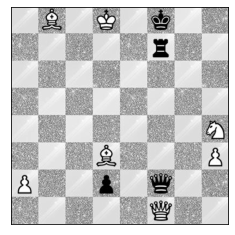

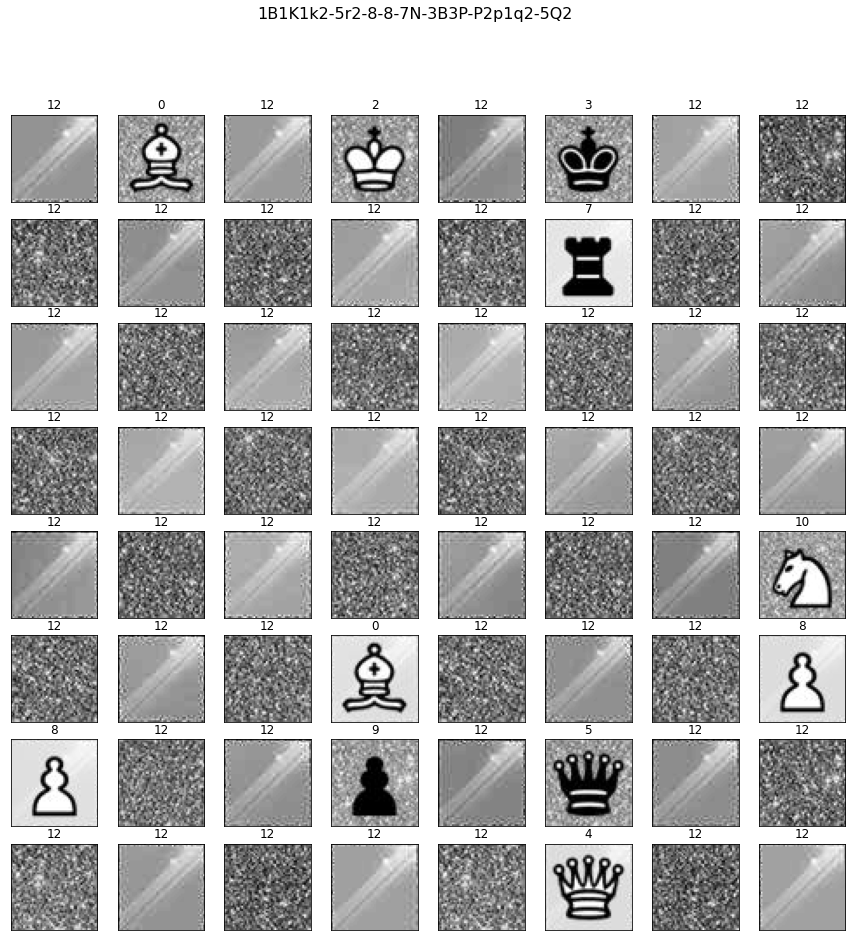

In [ ]:
#Example of reading a certain
name='1B1K1k2-5r2-8-8-7N-3B3P-P2p1q2-5Q2.jpeg'
img = cv2.imread('/content/drive/MyDrive/dataset/train/'+name,cv2.IMREAD_GRAYSCALE) 

plt.imshow(img.reshape(400,400),cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())

index2,y_1=read_picture(name,location='train')

plt.figure(figsize=(15, 15))
plt.suptitle("1B1K1k2-5r2-8-8-7N-3B3P-P2p1q2-5Q2", size=16)
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(index2[i,:].reshape(50,50),cmap=plt.cm.gray)
    plt.title(np.argmax(y_1,axis=1).reshape(1,-1)[0][i])
    plt.xticks(())
    plt.yticks(())

In [ ]:
Time=[]
size=50
loss=[]
acc=[]
start=time()

cnn=cnn_build()

for ep in range(60):
    
    chess=np.zeros((1,size**2))
    label=np.zeros((1,13))

    for name in sample(file,1):  #Randomly select one picture
        
        index2,y_1=read_picture(name,location='train')

        X_noempty=index2[y_1[:,12]==0] #Balance the number of empty blocks and the pieces
        y_noempty=y_1[y_1[:,12]==0]
        X_empty=index2[y_1[:,12]==1][0:len(y_noempty)//2,:]
        y_empty=y_1[y_1[:,12]==1][0:len(y_noempty)//2,:]

        chess=np.concatenate((chess,X_noempty,X_empty), axis=0)
        chess=chess/255 #Do the normalization
        label=np.concatenate((label,y_noempty,y_empty))
        
    # Train CNN
    train_history=cnn.fit(chess[1:,].reshape(len(chess)-1,50,50,1), label[1:,], epochs=10, batch_size=10,verbose=False)
    #acc.append(train_history.history['acc'][-1])
    #loss.append(train_history.history['loss'][-1])



#Test on test set
y_res=[]
y_res_class=np.zeros((1,1))
y_ture=np.zeros((1,1))
for name in test:

    chess2,y_1=read_picture(name,location='test')
    chess2=chess2/255
    y_pre=np.argmax(cnn.predict(chess2.reshape(len(chess2),50,50,1)),axis=1)
    y_res.append(make_name(y_pre))
    
    y_res_class=np.concatenate((y_res_class,y_pre[:,np.newaxis]))
    y_ture=np.concatenate((y_ture,np.argmax(y_1,axis=1)[:,np.newaxis]),axis=0)

Classifi_R=classification_report(y_ture[1:,], y_res_class[1:,],output_dict=True)
A=np.mean(np.array(y_res)==np.array(test))


Time.append(time()-start)

print('Accuracy:',A)
print('Time used:',Time[0])

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(classification_report(y_ture[1:,], y_res_class[1:,],output_dict=False))